# BERT

In [92]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/my-data/Data.xlsx
/kaggle/input/my-data-sentiment/data.csv


In [93]:

import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import StratifiedKFold
import torch.nn as nn
from tqdm import tqdm
import time
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import numpy as np
import nltk
import warnings  # Import the warnings module


In [94]:

file_path = '/kaggle/input/data/data.csv'
df = pd.read_csv(file_path, delimiter=',', encoding='latin1')


In [95]:
# column names
print(df.columns)

Index(['Comments', 'Sentiment'], dtype='object')


In [96]:
#Distribution of class 
class_distribution = df['Sentiment'].value_counts()
print("Class Distribution:")
print(class_distribution)

total_sentiments = len(df['Sentiment'])
print("Total:", total_sentiments)


Class Distribution:
Sentiment
negative    610
neutral     604
positive    598
Name: count, dtype: int64
Total: 1812


In [97]:
#Checking NUll
print("Null Values Before:")
print(df.isnull().sum())

Null Values Before:
Comments     0
Sentiment    0
dtype: int64


In [98]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [99]:
# Function to clean and preprocess text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

/opt/conda/lib/python3.10/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/usr/share/nltk_data/corpora/stopwords/english'>
  return concat([self.open(f).read() for f in fileids])


In [100]:

# def preprocess_text(text):
#     # Lowercasing
#     text = text.lower()
#     # Remove punctuation
#     text = ''.join([char for char in text if char not in string.punctuation])
#     # Tokenize
#     tokens = word_tokenize(text)
#     # Remove stopwords
#     tokens = [word for word in tokens if word not in stop_words]
#     # Lemmatization
#     tokens = [lemmatizer.lemmatize(word) for word in tokens]
#     # Remove emojis
#     tokens = [word for word in tokens if word.isalnum()]  # Removes emojis and special characters
#     return ' '.join(tokens)


In [101]:
# Convert string labels to numerical values
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['Sentiment'] = df['Sentiment'].map(label_mapping)

In [102]:
# Tokenization and Formatting for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [103]:
# Initialize cross-validation
num_splits = 5
skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

In [104]:
from transformers import logging
logging.set_verbosity_error()


In [105]:
# Initialize the BERT model without loading the classifier weights
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3, from_tf=False)
model.classifier =  nn.Sequential(
    nn.Dropout(0.6),  # dropout rate
    nn.Linear(model.config.hidden_size, 3)
)

In [106]:
# Loss function and optimizer with weight decay (L2 regularization)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)


In [107]:
# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [108]:
# Training loop with cross-validation and validation loss
num_epochs = 10
history = {'train_loss': [], 'val_loss': [], 'test_loss': [], 'train_acc': [], 'val_acc': [], 'test_acc': []}
early_stopping = {'epoch': 0, 'best_loss': np.inf, 'counter': 0, 'patience': 3}


In [109]:
# Initialize empty lists for overall class distribution
overall_train_labels = []
overall_val_labels = []
overall_test_labels = []


In [ ]:
from sklearn.exceptions import DeprecationWarning

warnings.filterwarnings("ignore", category=DeprecationWarning)


In [111]:

for fold, (train_idx, test_idx) in enumerate(skf.split(df['Comments'], df['Sentiment'])):
    print(f"\nFold {fold + 1}/{num_splits}")

    # Split data into training, validation, and testing sets
    train_texts, test_texts = df['Comments'].iloc[train_idx], df['Comments'].iloc[test_idx]
    train_labels, test_labels = df['Sentiment'].iloc[train_idx], df['Sentiment'].iloc[test_idx]

    # Use another split for validation within the training set
    train_idx, val_idx = next(skf.split(train_texts, train_labels))

    train_texts, val_texts = train_texts.iloc[train_idx], train_texts.iloc[val_idx]
    train_labels, val_labels = train_labels.iloc[train_idx], train_labels.iloc[val_idx]

    # Tokenization and formatting for BERT
    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=256, return_tensors='pt')
    val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=256, return_tensors='pt')
    test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=256, return_tensors='pt')

    # Convert labels to tensor
    train_labels = torch.tensor(train_labels.values, dtype=torch.long).to(device)
    val_labels = torch.tensor(val_labels.values, dtype=torch.long).to(device)
    test_labels = torch.tensor(test_labels.values, dtype=torch.long).to(device)

    # Move data to GPU
    train_encodings = {key: value.to(device) for key, value in train_encodings.items()}
    val_encodings = {key: value.to(device) for key, value in val_encodings.items()}
    test_encodings = {key: value.to(device) for key, value in test_encodings.items()}

    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
    test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    # Append labels for class distribution
    overall_train_labels.extend(train_labels.tolist())
    overall_val_labels.extend(val_labels.tolist())
    overall_test_labels.extend(test_labels.tolist())

    # Training loop
    model = initialize_bert_model()
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Training - Epoch {epoch + 1}")
        for step, batch in progress_bar:
            optimizer.zero_grad()
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
            outputs = model(**inputs)
            logits = outputs.logits
            loss = criterion(logits, inputs['labels'])
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted_train = torch.max(logits, 1)
            total_train += inputs['labels'].size(0)
            correct_train += (predicted_train == inputs['labels']).sum().item()

            progress_bar.set_postfix({'Train Loss': train_loss / (step + 1)})

        train_accuracy = correct_train / total_train
        avg_train_loss = train_loss / (step + 1)
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        progress_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Validation - Epoch {epoch + 1}")
        with torch.no_grad():
            for step, batch in progress_bar:
                inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
                outputs = model(**inputs)
                logits = outputs.logits
                loss = criterion(logits, inputs['labels'])

                val_loss += loss.item()
                _, predicted_val = torch.max(logits, 1)
                total_val += inputs['labels'].size(0)
                correct_val += (predicted_val == inputs['labels']).sum().item()

                progress_bar.set_postfix({'Validation Loss': val_loss / (step + 1)})

        val_accuracy = correct_val / total_val
        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs} => "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Acc: {val_accuracy:.4f}")

        # Early stopping
        if avg_val_loss < early_stopping['best_loss']:
            early_stopping['best_loss'] = avg_val_loss
            early_stopping['epoch'] = epoch
            early_stopping['counter'] = 0
        else:
            early_stopping['counter'] += 1
            if early_stopping['counter'] >= early_stopping['patience']:
                print(f"Early stopping at epoch {epoch + 1} based on validation loss.")
                break

# Print average performance across all folds
avg_train_acc = sum(history['train_acc']) / len(history['train_acc'])
avg_val_acc = sum(history['val_acc']) / len(history['val_acc'])
print(f"\nAverage Performance Across {num_splits} Folds => "
      f"Final Avg Train Acc: {avg_train_acc:.4f}, Final Avg Validation Acc: {avg_val_acc:.4f}")


Fold 1/5


Validation - Epoch 1: 100%|██████████| 73/73 [00:02<00:00, 26.98it/s, Validation Loss=0.512]


Epoch 1/10 => Train Loss: 0.8567, Train Acc: 0.6091, Validation Loss: 0.5120, Validation Acc: 0.8069


Validation - Epoch 2: 100%|██████████| 73/73 [00:02<00:00, 27.01it/s, Validation Loss=0.551]


Epoch 2/10 => Train Loss: 0.4344, Train Acc: 0.8481, Validation Loss: 0.5506, Validation Acc: 0.8069


Validation - Epoch 3: 100%|██████████| 73/73 [00:02<00:00, 27.01it/s, Validation Loss=0.627]


Epoch 3/10 => Train Loss: 0.1928, Train Acc: 0.9422, Validation Loss: 0.6271, Validation Acc: 0.8000


Validation - Epoch 4: 100%|██████████| 73/73 [00:02<00:00, 26.96it/s, Validation Loss=0.713]


Epoch 4/10 => Train Loss: 0.1090, Train Acc: 0.9646, Validation Loss: 0.7131, Validation Acc: 0.7724
Early stopping at epoch 4 based on validation loss.

Fold 2/5


Validation - Epoch 1: 100%|██████████| 73/73 [00:01<00:00, 52.51it/s, Validation Loss=0.577]


Epoch 1/10 => Train Loss: 0.9166, Train Acc: 0.5660, Validation Loss: 0.5770, Validation Acc: 0.7724
Early stopping at epoch 1 based on validation loss.

Fold 3/5


Validation - Epoch 1: 100%|██████████| 73/73 [00:01<00:00, 37.46it/s, Validation Loss=0.626]


Epoch 1/10 => Train Loss: 0.9135, Train Acc: 0.5612, Validation Loss: 0.6260, Validation Acc: 0.7862
Early stopping at epoch 1 based on validation loss.

Fold 4/5


Validation - Epoch 1: 100%|██████████| 73/73 [00:01<00:00, 58.57it/s, Validation Loss=0.507]


Epoch 1/10 => Train Loss: 0.8601, Train Acc: 0.6026, Validation Loss: 0.5067, Validation Acc: 0.8241


Validation - Epoch 2: 100%|██████████| 73/73 [00:01<00:00, 58.25it/s, Validation Loss=0.573]


Epoch 2/10 => Train Loss: 0.4030, Train Acc: 0.8603, Validation Loss: 0.5730, Validation Acc: 0.8172


Validation - Epoch 3: 100%|██████████| 73/73 [00:01<00:00, 57.33it/s, Validation Loss=0.621]


Epoch 3/10 => Train Loss: 0.1992, Train Acc: 0.9362, Validation Loss: 0.6212, Validation Acc: 0.7897


Validation - Epoch 4: 100%|██████████| 73/73 [00:01<00:00, 58.17it/s, Validation Loss=0.837]


Epoch 4/10 => Train Loss: 0.1256, Train Acc: 0.9638, Validation Loss: 0.8371, Validation Acc: 0.7828
Early stopping at epoch 4 based on validation loss.

Fold 5/5


Validation - Epoch 1: 100%|██████████| 73/73 [00:01<00:00, 58.60it/s, Validation Loss=0.622]

Epoch 1/10 => Train Loss: 0.9090, Train Acc: 0.5724, Validation Loss: 0.6222, Validation Acc: 0.7690
Early stopping at epoch 1 based on validation loss.

Average Performance Across 5 Folds => Final Avg Train Acc: 0.7722, Final Avg Validation Acc: 0.7920


In [112]:
# After training, evaluate on the test set
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_predictions = []
all_targets = []

progress_bar = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Testing")
with torch.no_grad():
    for step, batch in progress_bar:
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model(**inputs)
        logits = outputs.logits
        loss = criterion(logits, inputs['labels'])

        test_loss += loss.item()
        _, predicted_test = torch.max(logits, 1)
        total_test += inputs['labels'].size(0)
        correct_test += (predicted_test == inputs['labels']).sum().item()

        all_predictions.extend(predicted_test.cpu().numpy())
        all_targets.extend(inputs['labels'].cpu().numpy())

        progress_bar.set_postfix({'Test Loss': test_loss / (step + 1)})

test_accuracy = correct_test / total_test
avg_test_loss = test_loss / len(test_loader)
history['test_loss'].append(avg_test_loss)
history['test_acc'].append(test_accuracy)

print(f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")


Testing: 100%|██████████| 91/91 [00:01<00:00, 52.04it/s, Test Loss=0.561]

Test Loss: 0.5614, Test Acc: 0.7873


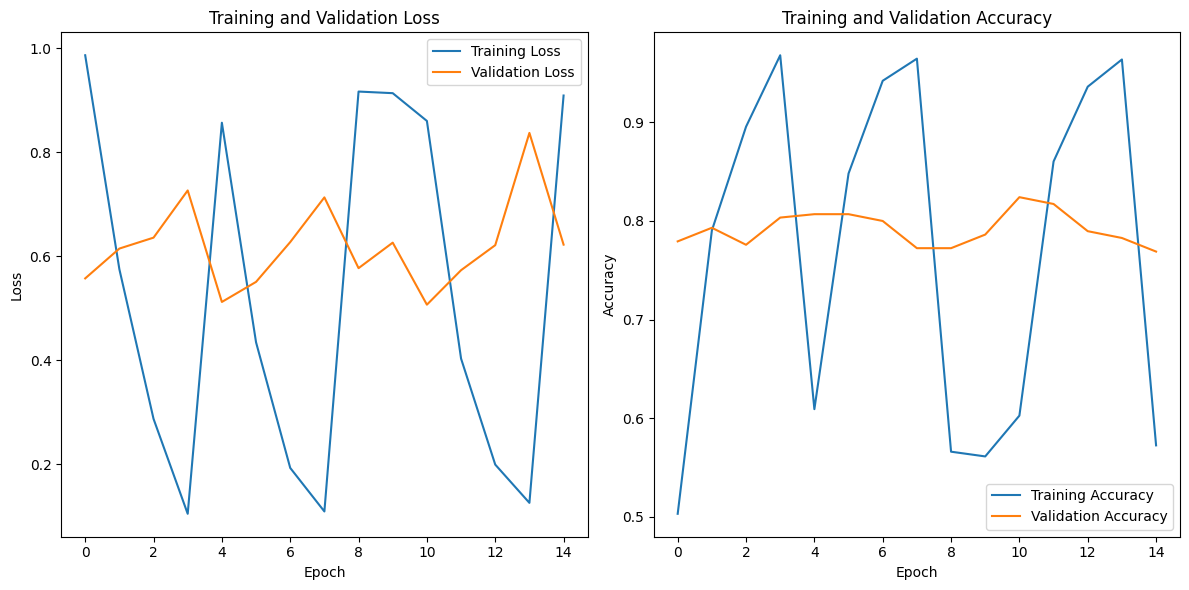

In [113]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


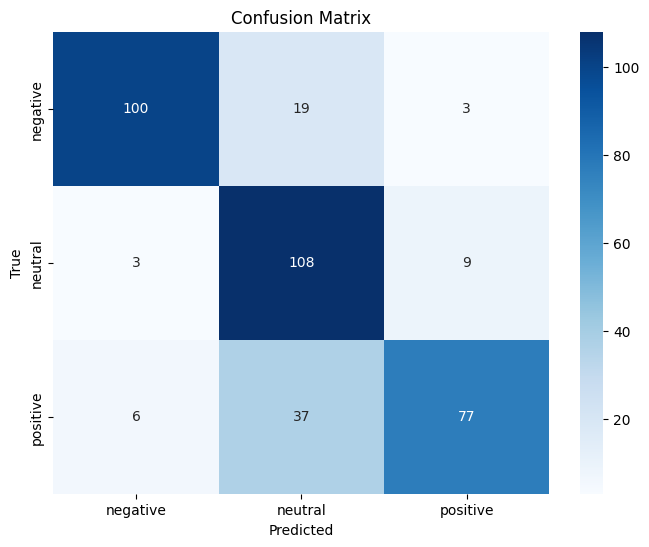

In [115]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [116]:
# Print overall class distribution after all folds
print("\nOverall Class Distribution:")
overall_train_distribution = pd.Series(overall_train_labels).value_counts()
overall_test_distribution = pd.Series(overall_test_labels).value_counts()

print("Train Class Distribution:")
print(overall_train_distribution)


print("\nTest Class Distribution:")
print(overall_test_distribution)


Overall Class Distribution:
Train Class Distribution:
0    2730
1    2705
2    2681
Name: count, dtype: int64

Test Class Distribution:
0    854
1    846
2    838
Name: count, dtype: int64


# Comparative Analysis

• BERT achieved the highest accuracy score among the classifiers, with a value of 0.78.

• SVM follows closely with an accuracy score of 0.71.

• The Voting Classifier lags behind with an accuracy score of 0.69.

Based on confusion Matrix:

BERT Performance:

• BERT exhibits better performance in accurately predicting all three classes
(Negative, Neutral, Positive) compared to SVM.

• BERT shows higher counts in the diagonal elements, indicating strong predictive
capability across all classes.

SVM Performance:

• SVM demonstrates reasonable performance, but it appears to struggle more in
distinguishing between classes, as evidenced by higher off-diagonal counts in the
confusion matrix.

Recommendation:

• Based on the confusion matrices, BERT seems to be the more reliable model,
achieving better accuracy in classifying instances across all sentiment classes